In [2]:
import xarray as xr
import pandas as pd

%matplotlib inline
import fiona
import rasterio
import rasterio.mask


import datetime as dt

import numpy as np



In [3]:
AWRA_APET = xr.open_dataset('/g/data/oe9/user/rg6346/PET_BOM_AWRA/aet_avg_Actual_month.nc')
AWRA_APET

<xarray.Dataset>
Dimensions:      (latitude: 681, longitude: 841, nv: 2, time: 217)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
  * latitude     (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude    (longitude) float64 112.0 112.0 112.1 112.2 112.2 112.2 ...
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) int32 ...
    etot_avg     (time, latitude, longitude) float64 ...
Attributes:
    var_name:  etot_avg

### Masking shapefile

In [4]:
import fiona
import rasterio
import rasterio.mask

# create geometry coordinates of shapefile boundary 
# open the MDB shapefile 
with fiona.open("/home/563/sl1412/rainfall/mdb_boundary/mdb_boundary.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
geoms

[{'coordinates': [[(146.88943187737294, -24.64027848277317),
    (146.88846192353657, -24.64262843314964),
    (146.88813201182728, -24.6451084706635),
    (146.89063199827063, -24.64569855664763),
    (146.89448180640278, -24.64440858174771),
    (146.89623178014932, -24.646038526640723),
    (146.89783188546704, -24.648238440950195),
    (146.90021184305687, -24.649868721119333),
    (146.90191169302244, -24.650628624461945),
    (146.90429165061227, -24.651228601091816),
    (146.9067316226289, -24.652168715352843),
    (146.90829166244936, -24.65333866139912),
    (146.90946160849575, -24.65547872891989),
    (146.91051169332655, -24.657618628802595),
    (146.91282174584381, -24.65924874133367),
    (146.91451170516365, -24.660008644676225),
    (146.91677146626188, -24.660318607455963),
    (146.91872143221843, -24.660508709020178),
    (146.92097147030887, -24.662538638333046),
    (146.9220614529989, -24.665318747980905),
    (146.92318144290215, -24.66693863459011),
    (146.9

In [5]:
# mask the SPI raster based on geoms 
with rasterio.open("/g/data/oe9/project/team-drip/pet_slice.nc") as src:
    out_image, out_transform = rasterio.mask.mask(src, geoms,
                                                        crop=True)
    out_meta = src.meta.copy()

In [6]:
out_meta

{'count': 1,
 'crs': None,
 'driver': 'netCDF',
 'dtype': 'float32',
 'height': 681,
 'nodata': -999.0,
 'transform': Affine(0.05, 0.0, 111.975,
       0.0, -0.05, -9.975),
 'width': 841}

In [7]:
out_transform # Affine transform variable used for rasterise the geoms 

Affine(0.05, 0.0, 138.52500000000001,
       0.0, -0.05, -24.575000000000003)

In [8]:
shape_data = AWRA_APET.etot_avg.isel(time=0).shape
shape_data # shape of the raster (no. of col and no. of rows)

(681, 841)

In [15]:
# create masking array 
import rasterio
from rasterio import features
mask = xr.DataArray(
    features.rasterize(geoms, out_shape=shape_data, transform=out_meta['transform'], all_touched= False),
    coords=AWRA_APET.etot_avg.isel(time=0).coords,
)
mask

<xarray.DataArray (latitude: 681, longitude: 841)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    time       datetime64[ns] 2000-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.2 112.2 112.2 112.3 ...

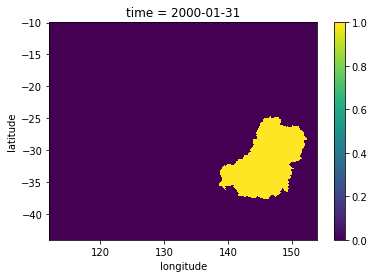

In [16]:
mask.plot.imshow()

In [17]:
subset = AWRA_APET.where(mask, drop=True)
subset

<xarray.Dataset>
Dimensions:      (latitude: 261, longitude: 278, nv: 2, time: 217)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
  * latitude     (latitude) float64 -24.65 -24.7 -24.75 -24.8 -24.85 -24.9 ...
  * longitude    (longitude) float64 138.6 138.7 138.7 138.8 138.8 138.8 ...
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv, latitude, longitude) float64 nan nan nan nan nan ...
    etot_avg     (time, latitude, longitude) float64 nan nan nan nan nan nan ...
Attributes:
    var_name:  etot_avg

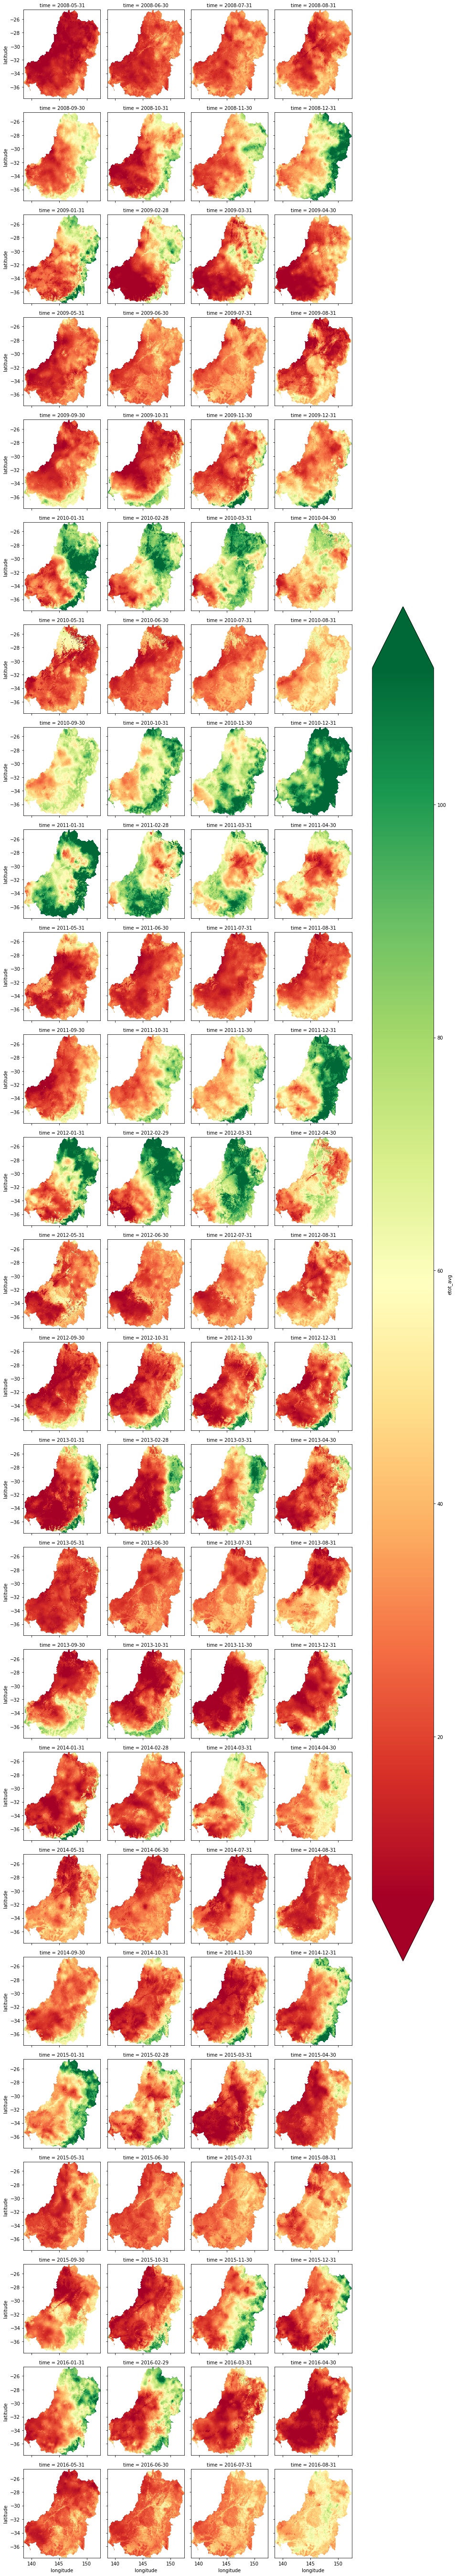

In [19]:
subset.etot_avg.isel(time=range(100,200)).plot.imshow(col='time', robust = True, col_wrap=4, cmap = 'RdYlGn')

In [18]:
# save the mask array into a nc file 
path = '/g/data/oe9/project/team-drip/MDB_MASK/MASK_ARRAY_AWRA.nc'
mask.to_netcdf(path, mode = 'w')

In [45]:
mask

<xarray.DataArray (y: 3147, x: 3346)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    band     int64 2
  * y        (y) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * x        (x) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
    time     datetime64[ns] 2000-02-18